# Train an autonomous car
- https://github.com/udacity/self-driving-car-sim
- https://github.com/Microsoft/AirSim

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import cv2
import os
import random
import ntpath
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from keras.optimizers import Adam


Using TensorFlow backend.


### Functions

In [69]:
def truncatePath(path):
    """Used to truncate path for the dataset"""
    head, tail = ntpath.split(path)
    return tail

def loadImages(df):
    """Loads the images and steering angles i.e. X,y"""
    paths = []
    angles = []
    for i in range(len(df)):
        idx = df.iloc[i]
        c, l, r = idx[0], idx[1], idx[2]
        paths.append(os.path.join('IMG/', c.strip()))
        angles.append((float(idx[3])))
    paths = np.asarray(paths)
    angles = np.asarray(angles)
    return paths, angles
        
def preProcess(img):
    """
    Slice the image, convert to YUV, blur the image, resize, and normalize
    https://devblogs.nvidia.com/deep-learning-self-driving-cars/
    TODO: merge these two functions
    """
    img = mpimg.imread(img)
    img = img[60:135,:,:]
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img = cv2.GaussianBlur(img, (3,3), 0)
    img = cv2.resize(img, (200, 66))
    img = img / 255
    return img

def preProcessBatch(img):
    """
    Slice the image, convert to YUV, blur the image, resize, and normalize
    https://devblogs.nvidia.com/deep-learning-self-driving-cars/
    """
    img = img[60:135,:,:]
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img = cv2.GaussianBlur(img, (3,3), 0)
    img = cv2.resize(img, (200, 66))
    img = img / 255
    return img

### Load the CSV and view the distribution

In [3]:
cols = ['center', 'left', 'right', 'angle', 'throttlePos', 'reverse', 'velocity']
df = pd.read_csv('driving_log.csv', names=cols)
df['center'] = df['center'].apply(truncatePath)
df['left'] = df['left'].apply(truncatePath)
df['right'] = df['right'].apply(truncatePath)
print(df.keys())
print(len(df))

Index(['center', 'left', 'right', 'angle', 'throttlePos', 'reverse',
       'velocity'],
      dtype='object')
13844


In [4]:
df.head()

center                              left  \
0  center_2019_02_10_23_04_38_410.jpg  left_2019_02_10_23_04_38_410.jpg   
1  center_2019_02_10_23_04_38_510.jpg  left_2019_02_10_23_04_38_510.jpg   
2  center_2019_02_10_23_04_38_615.jpg  left_2019_02_10_23_04_38_615.jpg   
3  center_2019_02_10_23_04_38_717.jpg  left_2019_02_10_23_04_38_717.jpg   
4  center_2019_02_10_23_04_38_820.jpg  left_2019_02_10_23_04_38_820.jpg   

                               right    angle  throttlePos  reverse  velocity  
0  right_2019_02_10_23_04_38_410.jpg  0.00000          1.0        0  30.19189  
1  right_2019_02_10_23_04_38_510.jpg  0.00000          1.0        0  30.19064  
2  right_2019_02_10_23_04_38_615.jpg  0.00000          1.0        0  30.18886  
3  right_2019_02_10_23_04_38_717.jpg -0.30720          1.0        0  30.16702  
4  right_2019_02_10_23_04_38_820.jpg -0.20672          1.0        0  30.18813

[-0.96774194 -0.90322581 -0.83870968 -0.77419355 -0.70967742 -0.64516129
 -0.58064516 -0.51612903 -0.4516129  -0.38709677 -0.32258065 -0.25806452
 -0.19354839 -0.12903226 -0.06451613  0.          0.06451613  0.12903226
  0.19354839  0.25806452  0.32258065  0.38709677  0.4516129   0.51612903
  0.58064516  0.64516129  0.70967742  0.77419355  0.83870968  0.90322581
  0.96774194]


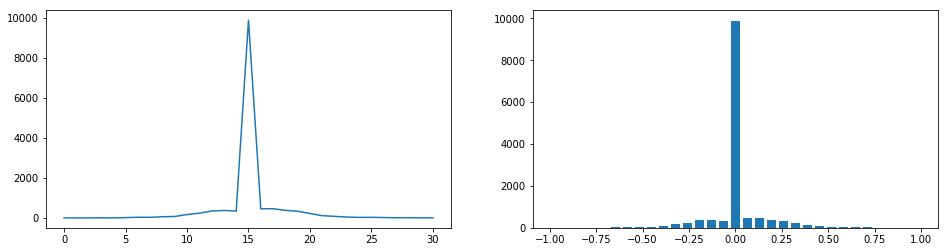

[-1.         -0.93548387 -0.87096774 -0.80645161 -0.74193548 -0.67741935
 -0.61290323 -0.5483871  -0.48387097 -0.41935484 -0.35483871 -0.29032258
 -0.22580645 -0.16129032 -0.09677419 -0.03225806  0.03225806  0.09677419
  0.16129032  0.22580645  0.29032258  0.35483871  0.41935484  0.48387097
  0.5483871   0.61290323  0.67741935  0.74193548  0.80645161  0.87096774
  0.93548387  1.        ]


In [5]:
nBins = 31 #arbitrary, but sort of not
hist, bins = np.histogram(df['angle'], nBins)
center = (bins[:-1]+bins[1:])/2
print(center)
fig=plt.figure(figsize=(16,4)) #8"x8" figure
fig.add_subplot(1,2, 1)
plt.plot(hist)
fig.add_subplot(1,2, 2)
plt.bar(center, hist, width=.05)
plt.show()
print(bins)

### balance the dataset

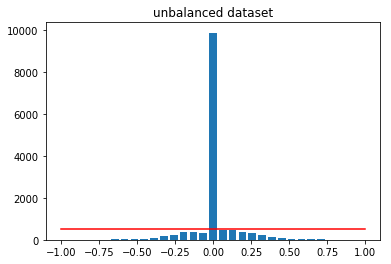

In [6]:
plt.bar(center, hist, width=.05)
maxSamples = 500
plt.plot((np.min(df['angle']), np.max(df['angle'])), (maxSamples, maxSamples), color='red')
plt.title("unbalanced dataset")
plt.show()

- find a good line for max samples
- loop through the angles, shuffl them, then discard > max amount

In [7]:
removed = []
for i in range(nBins):
    temp = []
    for j in range(0, len(df['angle'])):
        if (df['angle'][j] > bins[i] and df['angle'][j] <= bins[i+1]):
            temp.append(j)
    temp = shuffle(temp)
    temp = temp[maxSamples:]
    removed.extend(temp)
print('total: ', len(df))
print('removed: ', len(removed))
df.drop(df.index[removed], inplace=True)
print('remaining: ', len(df))

total:  13844
removed:  9385
remaining:  4459


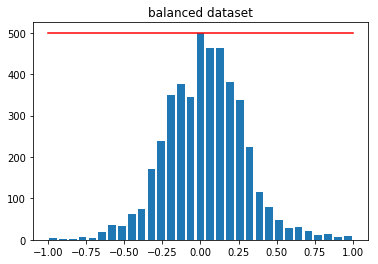

In [8]:
hist, bins = np.histogram(df['angle'], (nBins))
plt.bar(center, hist, width=.05)
plt.plot((np.min(df['angle']), np.max(df['angle'])), (maxSamples, maxSamples), color='red')
plt.title("balanced dataset")
plt.show()

### Now that the data set is balanced, load the images

In [9]:
x = [1,2,3,4,5,6,7,8,9]
y = [1,2,3,4,5,6,7,8,9]
x,y = shuffle(x,y)
print(x)
print(y)

[3, 6, 7, 2, 1, 5, 8, 4, 9]
[3, 6, 7, 2, 1, 5, 8, 4, 9]


In [10]:
paths, angles = loadImages(df)
paths, angles = shuffle(paths, angles)
X_train, X_valid, y_train, y_valid = train_test_split(paths, angles, test_size=.20)

In [11]:
print("Training samples: ", len(X_train))
print("validation samples: ", len(X_valid))
#print(X_train[0:5])
#print(paths[0:5])

Training samples:  3567
validation samples:  892


- Check out the distributions

Text(0.5, 1.0, 'validation set')

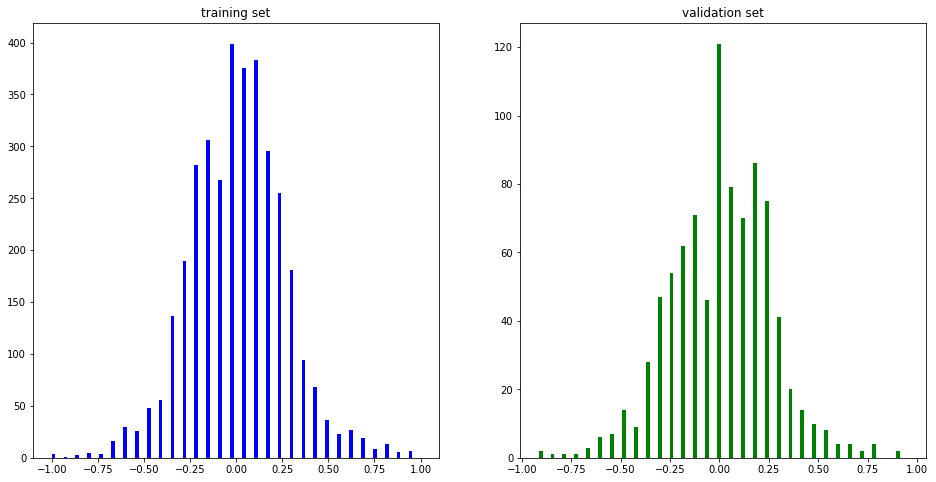

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
axes[0].hist(y_train, bins=nBins, width=.02, color='blue')
axes[0].set_title('training set')
axes[1].hist(y_valid, bins=nBins, width=.02, color='green')
axes[1].set_title('validation set')

### View the dataset

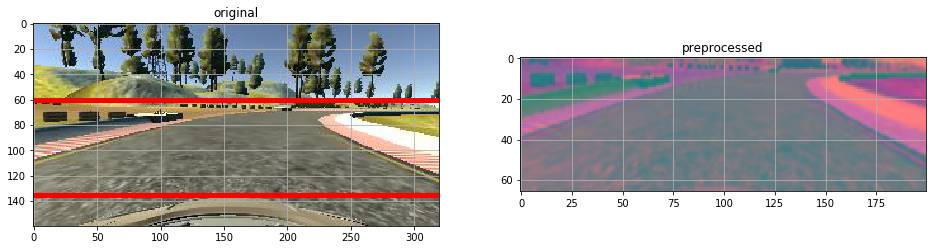

In [13]:
sample = paths[46]
orig = mpimg.imread(sample)
proc = preProcess(sample)

fig, axes = plt.subplots(1, 2, figsize=(16, 8))
axes[0].imshow(orig)
axes[0].set_title('original')
axes[0].grid()
axes[0].axhline(y=60, color='red', linewidth=5)
axes[0].axhline(y=135, color='red', linewidth=5)
axes[1].imshow(proc)
axes[1].set_title('preprocessed')
axes[1].grid()
plt.show()

### Preprocess the dataset

In [14]:
X_train = np.array(list(map(preProcess, X_train)))
X_valid = np.array(list(map(preProcess, X_valid)))

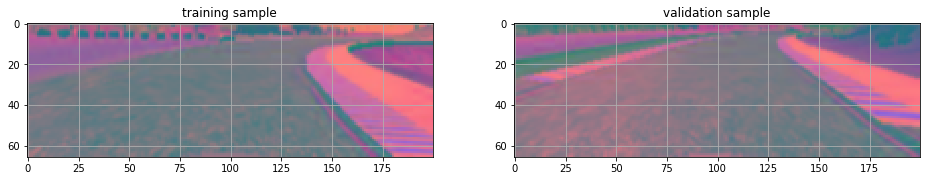

(3567, 66, 200, 3)


In [15]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
axes[0].imshow(X_train[random.randint(0, len(X_train)-1)])
axes[0].set_title('training sample')
axes[0].grid()
axes[1].imshow(X_valid[random.randint(0, len(X_valid)-1)])
axes[1].set_title('validation sample')
axes[1].grid()
plt.show()
print(X_train.shape)

### Create NVIDIA model
- https://github.com/Yunski/nvidia-cnn
- https://devblogs.nvidia.com/deep-learning-self-driving-cars/

In [92]:
def nvidiaModel():
    """Nvidia model, loss is mse due to regression and not classification"""
    model=Sequential()
    model.add(Conv2D(24, (5,5), subsample=(2,2), input_shape=(66,200,3), activation='elu'))
    model.add(Conv2D(36, (5,5), subsample=(2,2), activation='elu'))
    model.add(Conv2D(48, (5,5), subsample=(2,2), activation='elu'))
    model.add(Conv2D(64, (3,3), activation='elu'))
    model.add(Conv2D(64, (3,3), activation='elu'))
    model.add(Dropout(.5))
    model.add(Flatten())
    model.add(Dense(100, activation='elu'))
    model.add(Dropout(.5))
    model.add(Dense(50, activation='elu'))
    #model.add(Dropout(.2))
    model.add(Dense(10, activation='elu'))
    #model.add(Dropout(.2))
    model.add(Dense(1))
    model.compile(Adam(.001), loss='mse')
    return model
    

In [17]:
model = nvidiaModel()
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 1, 18, 64)         36928     
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 18, 64)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)              0         
__________

/home/tdarrah/anaconda3/envs/auto36/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), input_shape=(66, 200, ..., activation="elu", strides=(2, 2))`
  after removing the cwd from sys.path.
/home/tdarrah/anaconda3/envs/auto36/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), activation="elu", strides=(2, 2))`
  """
/home/tdarrah/anaconda3/envs/auto36/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (5, 5), activation="elu", strides=(2, 2))`
  


### Fit the model

In [18]:
hist = model.fit(X_train, y_train, epochs=7, validation_data=(X_valid, y_valid), batch_size=50, verbose=1, shuffle=1)

Train on 3567 samples, validate on 892 samples
Epoch 1/7
3567/3567 [==============================] - 14s 4ms/step - loss: 0.1509 - val_loss: 0.0529
Epoch 2/7
3567/3567 [==============================] - 15s 4ms/step - loss: 0.0534 - val_loss: 0.0427
Epoch 3/7
3567/3567 [==============================] - 14s 4ms/step - loss: 0.0440 - val_loss: 0.0373
Epoch 4/7
3567/3567 [==============================] - 14s 4ms/step - loss: 0.0414 - val_loss: 0.0344
Epoch 5/7
3567/3567 [==============================] - 15s 4ms/step - loss: 0.0373 - val_loss: 0.0340
Epoch 6/7
3567/3567 [==============================] - 15s 4ms/step - loss: 0.0361 - val_loss: 0.0295
Epoch 7/7
3567/3567 [==============================] - 15s 4ms/step - loss: 0.0346 - val_loss: 0.0292


### Model Performance

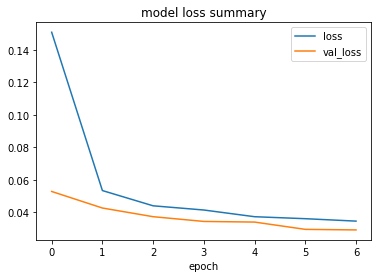

In [19]:
plt.plot(hist.history['loss'], label="loss")
plt.plot(hist.history['val_loss'], label="val_loss")
plt.title("model loss summary")
plt.xlabel("epoch")
plt.legend()

In [20]:
model.save('model1.h5')

### Build a data augmentation generator
- imgaug library https://github.com/aleju/imgaug
- https://imgaug.readthedocs.io/en/latest/

In [21]:
from imgaug import augmenters as ia

In [67]:
def compare(img1, img2, title1, title2):
    fig, axes = plt.subplots(1,2, figsize=(12,6))
    axes[0].imshow(img1)
    axes[0].set_title(title1)
    axes[1].imshow(img2)
    axes[1].set_title(title2)
    plt.show()
    
def zoom(img):
    zoom = ia.Affine(scale=(1, 1.25))
    return zoom.augment_image(img)

def pan(img):
    pan = ia.Affine(translate_percent = {"x" : (-.1, .1), "y" : (-.1, .1)})
    return pan.augment_image(img)

def randBrightness(img):
    brightness = ia.Multiply((0.2, 1.2))
    return brightness.augment_image(img)
    
def randFlip(img, angle):
    img = cv2.flip(img,1)
    angle = -angle
    return img, angle

def randAugment(img, angle):
    img = mpimg.imread(img)
    if(np.random.rand() < .5):
        img = pan(img)
    if(np.random.rand() < .5):
        img = zoom(img)
    if(np.random.rand() < .5):
        img = randBrightness(img)
    if(np.random.rand() < .5):
        img, angle = randFlip(img, angle)
    return img, angle

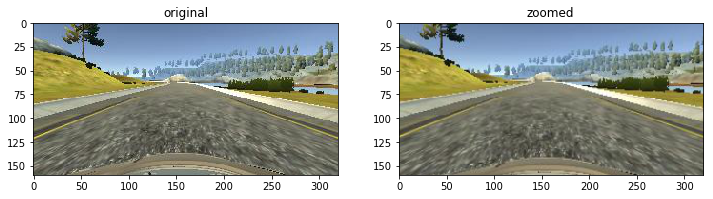

In [30]:
randIndex = random.randint(0, len(paths))
img = paths[randIndex]
orig = mpimg.imread(img)
zoomed = zoom(orig)
compare(orig, zoomed, "original", "zoomed")

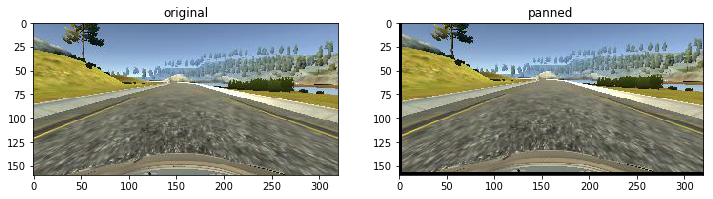

In [31]:
panned = pan(orig)
compare(orig, panned, "original", "panned")

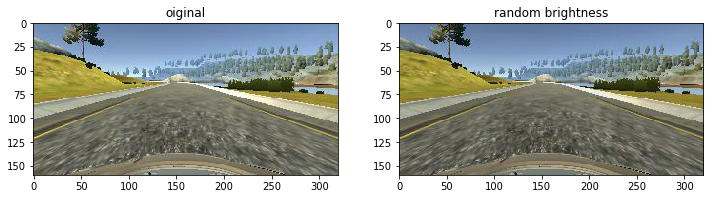

In [32]:
randbright = randBrightness(orig)
compare(orig, randbright, "oiginal", "random brightness")

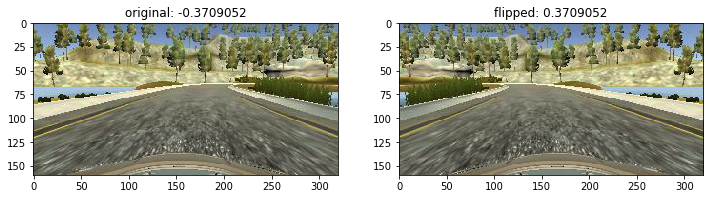

In [48]:
angle = angles[randIndex]
flippedImg, flippedAngle = randFlip(orig, angle)
compare(orig, flippedImg, str("original: " + str(angle)), str("flipped: " + str(flippedAngle)))

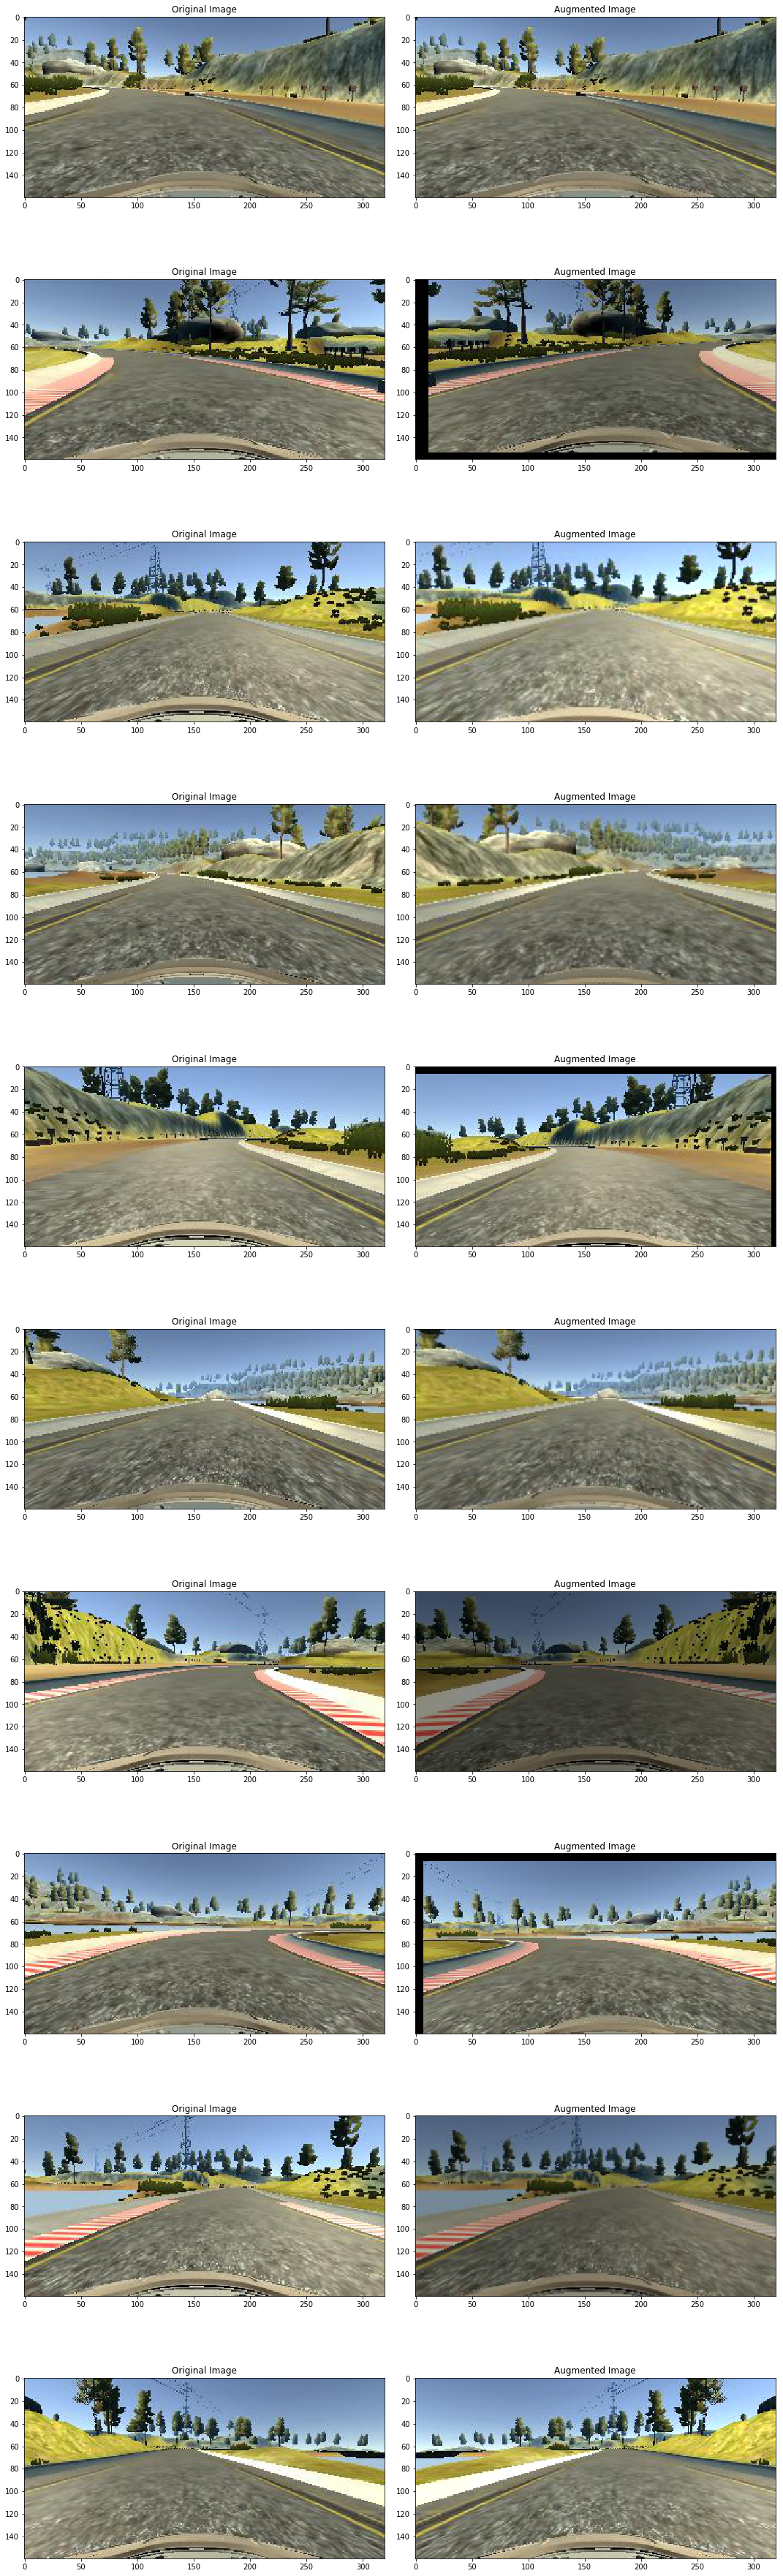

In [68]:
fig, axs = plt.subplots(10,2, figsize=(15, 50))
fig.tight_layout()
 
for i in range(10):
    rand = random.randint(0, len(paths) - 1)
    randImg = paths[rand]
    randAngle = angles[rand]
    
    orig = mpimg.imread(randImg)
    aug, angle = randAugment(randImg, randAngle)
    
    axs[i][0].imshow(orig)
    axs[i][0].set_title("Original Image")
  
    axs[i][1].imshow(aug)
    axs[i][1].set_title("Augmented Image")

### Create a batch generator
- yield generator https://jeffknupp.com/blog/2013/04/07/improve-your-python-yield-and-generators-explained/
- ***need to reload the dataset!***

In [80]:
paths, angles = loadImages(df)
paths, angles = shuffle(paths, angles)
X_train, X_valid, y_train, y_valid = train_test_split(paths, angles, test_size=.20)

In [85]:
def batchGenerator(paths, angles, batchSize, isTraining):
    """Yields batches of images and angles"""
    while(True):
        batchImgs = []
        batchAngles = []
        for i in range(0, batchSize):
            rand = random.randint(0, len(paths) - 1)
            randImg = paths[rand]
            randAngle = angles[rand]
            if(isTraining):
                pass
                img, angle = randAugment(randImg, randAngle)
            else:
                img = mpimg.imread(randImg)
                angle = randAngle
            img = preProcessBatch(img)
            batchImgs.append(img)
            batchAngles.append(angle)
        yield (np.asarray(batchImgs), np.asarray(batchAngles))

In [86]:
xtg, ytg = next(batchGenerator(X_train, y_train, 1, 1))
xvg, yvg = next(batchGenerator(X_train, y_train, 1, 0))

Text(0.5, 1.0, 'Validation Image')

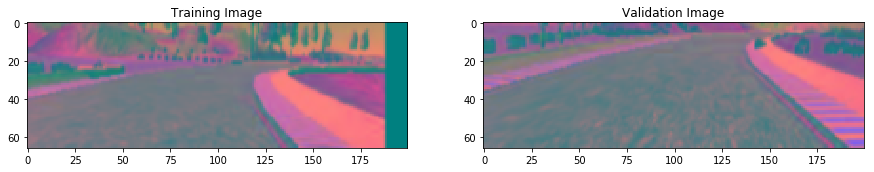

In [87]:
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
axs[0].imshow(xtg[0])
axs[0].set_title('Training Image')
 
axs[1].imshow(xvg[0])
axs[1].set_title('Validation Image')

### Fit a second model to the augmented dataset

In [93]:
model2 = nvidiaModel()

/home/tdarrah/anaconda3/envs/auto36/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), input_shape=(66, 200, ..., activation="elu", strides=(2, 2))`
  after removing the cwd from sys.path.
/home/tdarrah/anaconda3/envs/auto36/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), activation="elu", strides=(2, 2))`
  """
/home/tdarrah/anaconda3/envs/auto36/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (5, 5), activation="elu", strides=(2, 2))`
  


In [94]:
hist2 = model2.fit_generator(batchGenerator(X_train, y_train, 100, 1), 
                             steps_per_epoch=200, epochs=10, 
                             validation_data=batchGenerator(X_valid, y_valid, 100, 0), 
                             validation_steps=150, verbose=1, shuffle=1)

Epoch 1/10
200/200 [==============================] - 120s 602ms/step - loss: 0.0931 - val_loss: 0.0436
Epoch 2/10
200/200 [==============================] - 120s 598ms/step - loss: 0.0535 - val_loss: 0.0395
Epoch 3/10
200/200 [==============================] - 126s 630ms/step - loss: 0.0498 - val_loss: 0.0368
Epoch 4/10
200/200 [==============================] - 118s 589ms/step - loss: 0.0467 - val_loss: 0.0357
Epoch 5/10
200/200 [==============================] - 115s 575ms/step - loss: 0.0453 - val_loss: 0.0334
Epoch 6/10
200/200 [==============================] - 113s 563ms/step - loss: 0.0435 - val_loss: 0.0313
Epoch 7/10
200/200 [==============================] - 108s 540ms/step - loss: 0.0427 - val_loss: 0.0317
Epoch 8/10
200/200 [==============================] - 108s 539ms/step - loss: 0.0418 - val_loss: 0.0317
Epoch 9/10
200/200 [==============================] - 107s 537ms/step - loss: 0.0405 - val_loss: 0.0332
Epoch 10/10
200/200 [==============================] - 107s 534m

In [95]:
model2.save('model2.h5')

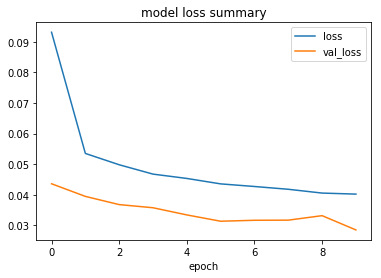

In [96]:
plt.plot(hist2.history['loss'], label="loss")
plt.plot(hist2.history['val_loss'], label="val_loss")
plt.title("model loss summary")
plt.xlabel("epoch")
plt.legend()